In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()

plt.rcParams['text.color'] = 'gray'
plt.rcParams['axes.labelcolor'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'

In [2]:
def pickling_function(pickle_object):
    pickle_name = input('Provide a filename: ')
    with open(f'{pickle_name}', 'wb') as f:
        pickle.dump(pickle_object, f)

    pickle_in = open(f'{pickle_name}', 'rb')
    pickled = pickle.load(pickle_in)
    return pickled

Load the data.

In [3]:
with open('holdoutdata', 'rb') as f:
    hold_out = pickle.load(f)

In [4]:
with open('trainingdata', 'rb') as f:
    trainingdata = pickle.load(f)

Split the train and test data into targets and features.

In [207]:
y_train = trainingdata['crop']
X_train = trainingdata.drop('crop', axis=1)

y_test = hold_out['crop']
X_test = hold_out.drop('crop', axis=1)

Initialize the models and create pipelines for each model. Preprocessing steps for each model include StandardScaler() and PCA(n_components=19).

In [6]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [217]:
pipes = []
models = [LogisticRegression(multi_class='ovr', solver='liblinear'), KNeighborsClassifier(), RandomForestClassifier()]
for model in models:
    pipe = make_pipeline(StandardScaler(),\
        PCA(n_components=19), \
        model)
    pipes.append(pipe)


Fit and score models on the training sets.

In [218]:
pipes[0].fit(X_train, y_train)
pipes[0].score(X_train, y_train)

0.9683232643941733

In [219]:
pipes[2].fit(X_train, y_train)
pipes[2].score(X_train, y_train)

0.9999289539572646

In [220]:
pipes[1].fit(X_train, y_train)
pipes[1].score(X_train, y_train)

0.9982311985222423

The initial fits of the training data to the 3 models appear to be appropriate. In fact every model fit to the train set scored higher than the goal threshold. However, the cross validation is necessary to ensure that the models are generalizable to new data and ensure we are selecting the best model prior evaluating on the test data. Roc_auc_score will be used as the scoring metric going forward because while we care about correctly predicting TP for field crops, we also care about predicting TN negatives. Roc_auc is also a great metric for our needs because SMOTE perfectly balanced the dataset across classes. Since fields can occuppy very large tracts of land and many farms operate multiple fields, we want to ensure that we are sending the correct seed salespeople to the correct farms. As transportation costs for work travel are covered by the business.

In [12]:
cv_scores = {}
for pipe in pipes:
    score = cross_val_score(pipe, X_train, y_train, scoring='roc_auc_ovr', cv=5)
    cv_scores[str(pipe[-1])] = score

In [13]:
for k in cv_scores.keys():
    print(k + ' average score: ' + str(np.mean(cv_scores[k])))

LogisticRegression(multi_class='ovr', solver='liblinear') average score: 0.996298039276812
KNeighborsClassifier() average score: 0.9996520716306959
RandomForestClassifier() average score: 0.9999281480855174


Again every model performs exceptionally well, even with cross validation. Let's visualize the confusion matrix for each model.

LogisticRegression(multi_class='ovr', solver='liblinear')


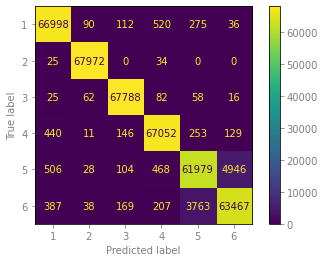

KNeighborsClassifier()


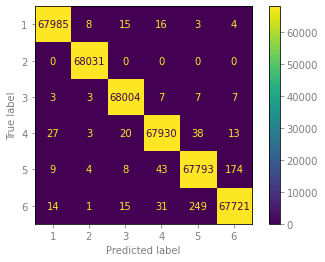

RandomForestClassifier()


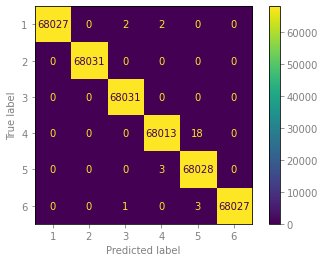

In [224]:
training_preds = {}

for pipe in pipes:
    preds = pipe.predict(X_train)
    print(pipe[-1], end='\n')
    cm = confusion_matrix(y_train, preds, labels=pipe.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    training_preds[pipe] = [preds, cm, disp]
    disp.plot()

    plt.show()

From this we can see that the Random Forest Classifier does the best job on classifing the training data. We will use the fitted RF model to predict on the test set.

0.9998637607796215


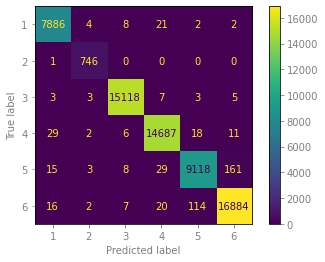

In [74]:
rf_pipe = pipes[2]
rf_preds = rf_pipe.predict(X_test)

cm = confusion_matrix(y_test, preds, labels=rf_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipe.classes_)
disp.plot()
roc_auc = roc_auc_score(y_test, rf_pipe.predict_proba(X_test), multi_class='ovr')
print(roc_auc)

plt.show()

The RF model performs exceptionally well on the test. Even without hyperparameter tuning the the model returns an roc_auc score of .99986 on the test data. Given that hyperparameter tuning can be both computational and time expensive and the model fit with default parameters is already achieve an roc_auc score near 1, hyperparameter tuning will not be done. In addition, I do not believe that training a neural network will yield a significant improvement. So the chosen RF model will be chosen as the winning model and is what a would recommend the company implement in their crop identification needs prior to market entry. 

In order to further understand the results of the RF model above, we will explore the Shapely values. Shapely values use game theory to determine how much importance a given feature has on a particular outcome. In the case of this model, it will enable us to identify which principal components are most important for classifying each crop.

In [58]:
pca_labels = ['PC' + str(x) for x in range(1,20)]

In [127]:
pca = PCA(n_components=19)
scaler = StandardScaler()

In [128]:
scaled_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
pca_train = pd.DataFrame(pca.fit_transform(scaled_train), index=X_train.index, \
    columns=pca_labels)

In [129]:
idx_filter = pca_train.index == y_train.index
len(y_train) == len(pca_train[idx_filter])

True

In [130]:
model = RandomForestClassifier().fit(pca_train, y_train)

In [132]:
scaled_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
pca_test = pd.DataFrame(pca.transform(scaled_test), index=X_test.index, \
    columns=pca_labels)

In [150]:
predicted_y = pd.DataFrame(model.predict(pca_test), index=X_test.index)
predicted_y.columns = ['predicted']

In [155]:
shap_dict = {
    'pca':pca,
    'scaler':scaler,
    'pca_train':pca_train,
    'train_y':y_train,
    'pca_test':pca_test,
    'test_y':y_test,
    'model':model,
    'predicted_y':predicted_y
}

In [156]:
pickling_function(shap_dict)

{'pca': PCA(n_components=19),
 'scaler': StandardScaler(),
 'pca_train':              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
 0       6.159747 -1.768011  7.799530  2.027251 -0.635287  1.999847 -1.082220   
 1      -1.319970 -4.453601 -3.302024 -2.596494  0.222081 -0.531451  0.609357   
 2       5.372596  0.086979  3.651850  3.869192  2.419263 -4.994474 -0.198320   
 3       2.119182 -4.359273 -0.657969  1.883511  2.835145 -1.018452  1.456620   
 4       2.747432 -4.789638 -6.077930  0.931846  5.194187 -3.188140  4.857718   
 ...          ...       ...       ...       ...       ...       ...       ...   
 408181 -0.681464 -2.411168  3.488681 -1.338617  3.933729 -1.975307 -1.035269   
 408182  7.501613 -3.041136  4.761438 -1.379047 -0.863938  5.533731  1.403334   
 408183  5.060757 -1.530180  5.844675 -1.464570 -1.260514 -0.791274  1.116590   
 408184  5.236777 -2.274436  4.625186  0.138244 -0.714935 -1.034750 -1.237462   
 408185  6.981856 -3.472787  5.213190

In [161]:
shap_preds = shap_dict['predicted_y']
shap_xtrain = shap_dict['pca_train']
shap_xtest = shap_dict['pca_test']
shap_ytrain = shap_dict['train_y']
shap_ytest = shap_dict['test_y']
shap_model = shap_dict['model']

In [163]:
explainer = shap.TreeExplainer(shap_model)

In [167]:
shap_X = shap_xtest.iloc[:100]

In [169]:
shap_values = explainer.shap_values(shap_X)

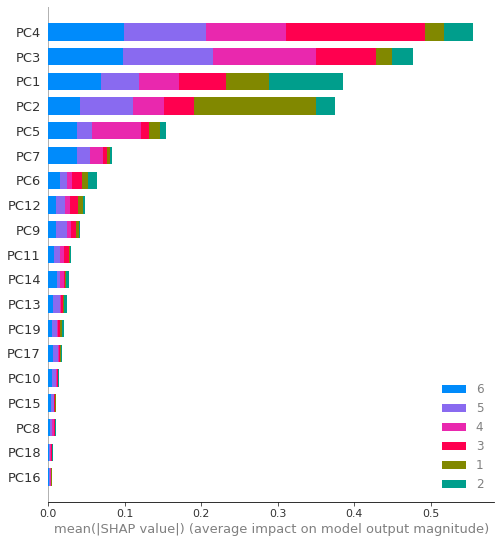

In [190]:
shap.summary_plot(shap_values, shap_X, class_names=model.classes_)

The above figure shows the global interpretability of the model, or each PC's overall relative importance is to predicting field crop across the model. From this we can see, that despite being the 4th in inertia value, PC4 is the most important feature in differentiating almost every crop (followed by PC3, PC1, and PC2). Below we will explore each PC's local interpretability.

Class 1


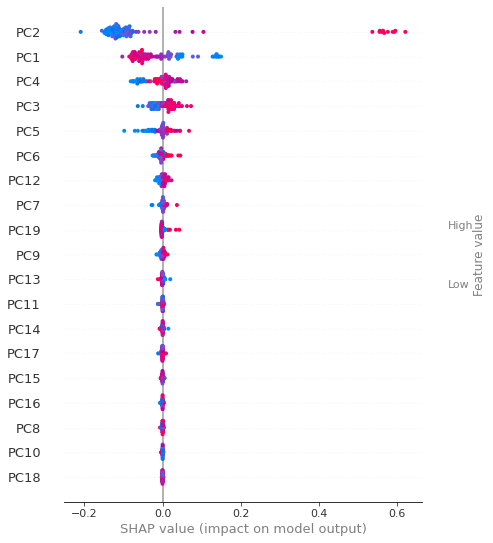

Class 2


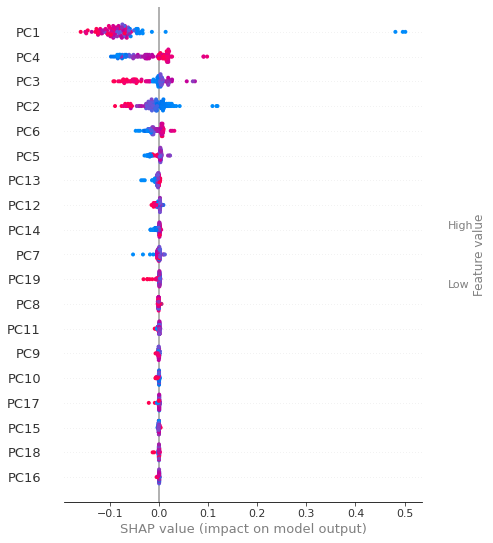

Class 3


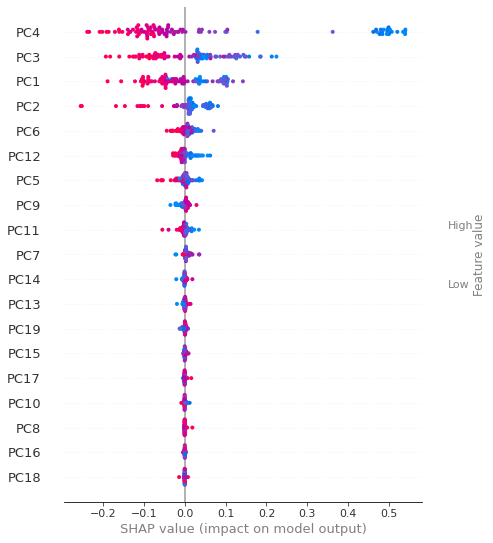

Class 4


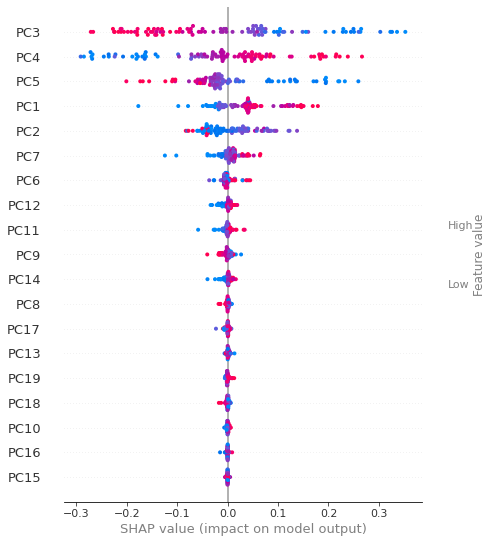

Class 5


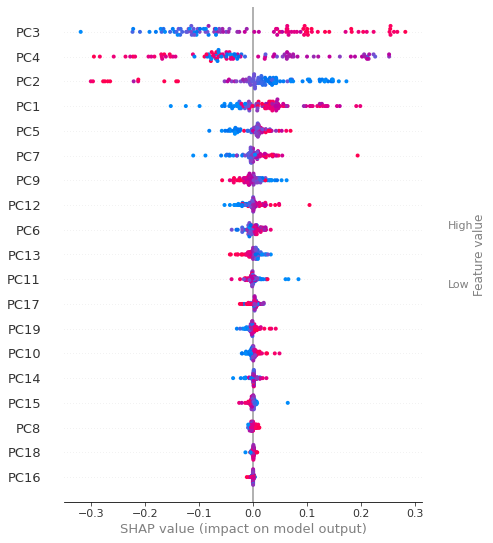

Class 6


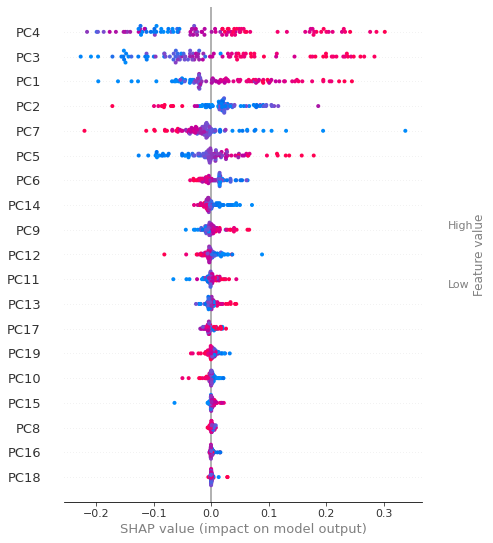

In [ ]:
for i in range(len(shap_values)):
    print('Class ' + str(i+1))
    shap.summary_plot(shap_values[i], shap_X, class_names=model.classes_)
    plt.show()